# Evaluate forecasts

In this notebook, we will compute all the scores for the baseline models and create the figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
from collections import OrderedDict

In [12]:
import pickle
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
res = '5.625'
DATADIR = f'/data/WeatherBench/{res}deg/'
PREDDIR = '/data/WeatherBench/baselines/'

## Load data

First let's load all the prediction files from the previous notebooks.

In [6]:
# Load the validation subset of the data: 2017 and 2018
# Ok, actually it's the TEST data but here we will just call it valid
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
# for precipitation we are taking 6 hourly accumulations
tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}2m_temperature', 't2m')
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid])

In [7]:
# to speed things up, let's only evaluate every 6th hour
valid_data = valid_data.isel(time=slice(0, None, 6))

In [8]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')

In [9]:
variables = ['z', 't', 'tp', 't2m']
lr_3d = xr.merge([xr.open_dataset(f'{PREDDIR}lr_3d_{v}_{v}.nc') for v in variables])
lr_5d = xr.merge([xr.open_dataset(f'{PREDDIR}lr_5d_{v}_{v}.nc') for v in variables])
lr_6h_iter = xr.open_dataset(f'{PREDDIR}lr_6h_iter.nc')

In [10]:
cnn_3d = xr.open_dataset(f'{PREDDIR}fccnn_3d.nc')
cnn_5d = xr.open_dataset(f'{PREDDIR}fccnn_5d.nc')
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}fccnn_6h_iter.nc')

In [11]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')
t63 = xr.open_dataset(f'{PREDDIR}/t63_5.625deg.nc')

## TIGGE data

*You do not need to execute these steps for TIGGE and T42/T63 if you already opened the datasets in the cell above.*

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

Note that the `tigge_z_t` file was preprocessed with a previous version of the TIGGE data. Unfortunatly, some of the data on the MARS archive seem to be corrupted at the moment. For the `t2m` and `tp` fields only the files for from 2018-1 to 2018-12 were downloadable at the time.

In [25]:
variables = ['2m_temperature', 'total_precipitation']

In [26]:
tigge_raw = xr.merge([
    xr.open_mfdataset(
        f'/media/rasp/Elements/WeatherBench/tigge/{res}deg/{v}/*2018*.nc',
        combine='by_coords'
    ).squeeze().drop(['valid_time'])   # Necessaary to avoid weird error
    for v in variables
])

In [27]:
tigge_raw = tigge_raw.rename({'step': 'lead_time'})

In [28]:
# Again we want 6 hourly accumulations, not accumulation since initialization
# Further we want [m] not [kg m**-2], so we divide by 1000
tigge_raw['tp'] = tigge_raw.tp.diff('lead_time') / 1000.

In [29]:
tigge_z_t = xr.open_dataset(f'{PREDDIR}/tigge_z_t_{res}deg.nc')

In [30]:
tigge_raw['lead_time'] = tigge_z_t.lead_time

In [31]:
tigge = xr.merge([tigge_z_t, tigge_raw])

In [32]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')

## IFS T42 and T63

These are IFS forecasts run at lower resolutions. Again we need to do some preprocessing

In [6]:
def convert_time(ds, nlead_time, dt_h=6):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, dt_h*nlead_time, dt_h), dims=['lead_time'], coords={'lead_time': np.arange(0, dt_h*nlead_time, dt_h)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [7]:
def fix_lat_lon(ds):
    "Not necessary for current version"
    ds = ds.sortby('lat')
    ds['lat'] = valid_data.lat
    ds = ds.roll(lon=32, roll_coords='lon')
    ds['lon'] = valid_data.lon
    return ds

#### T42

In [8]:
!ls -lh /media/rasp/Elements/WeatherBench/IFS_T42/*.nc

-rwxrwxrwx 1 rasp rasp  48M Feb  1 10:29 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_lnsp_2.8125_2.nc
-rwxrwxrwx 1 rasp rasp  49M Feb  1 10:29 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_lnsp_2.8125.nc
-rwxrwxrwx 1 rasp rasp  12M Feb  1 10:29 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_lnsp_5.625_2.nc
-rwxrwxrwx 1 rasp rasp  13M Feb  1 10:29 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_lnsp_5.625.nc
-rwxrwxrwx 1 rasp rasp 943M Feb  1 10:30 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_2.8125_2.nc
-rwxrwxrwx 1 rasp rasp 961M Feb  1 10:31 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_2.8125.nc
-rwxrwxrwx 1 rasp rasp 236M Feb  1 10:47 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_5.625deg_2.nc
-rwxrwxrwx 1 rasp rasp 241M Feb  1 10:46 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_5.625deg.nc
-rwxrwxrwx 1 rasp rasp  95M Feb  1 10:32 /media/rasp/Elements/WeatherBench/IFS_T42/output_42_sfc_2.8125_2.nc
-rwxrwxrwx 1 rasp rasp  9

In [10]:
t42_raw1 = xr.open_mfdataset(
    '/media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_5.625*.nc',
    combine='nested', concat_dim='time'
)
t42_raw2 = xr.open_mfdataset(
    '/media/rasp/Elements/WeatherBench/IFS_T42/output_42_sfc_5.625*.nc',
    combine='nested', concat_dim='time'
)

In [11]:
t42_raw = xr.merge([t42_raw1, fix_lat_lon(t42_raw2)])

In [12]:
3045/29

105.0

In [13]:
# Pick variables we want to evaluate
t42 = xr.merge([
    t42_raw.z.sel(lev=500e2).drop('lev'),
    t42_raw.t.sel(lev=850e2).drop('lev'),
    t42_raw['2t']
])

In [14]:
t42 = convert_time(t42, 29)

In [15]:
t42 = t42.sortby('time').rename({'2t': 't2m'})

In [16]:
t42.to_netcdf(f'{PREDDIR}/t42_5.625deg.nc')

#### T63

In [18]:
t63_raw1 = xr.open_mfdataset(
    '/media/rasp/Elements/WeatherBench/IFS_T63/output_63_pl_5.625*.nc',
    combine='nested', concat_dim='time'
)
t63_raw2 = xr.open_mfdataset(
    '/media/rasp/Elements/WeatherBench/IFS_T63/output_63_sfc_5.625*.nc',
    combine='nested', concat_dim='time'
)

In [19]:
t63_raw = fix_lat_lon(xr.merge([t63_raw1, t63_raw2]))

In [20]:
1575/15

105.0

In [21]:
# Pick variables we want to evaluate
t63 = xr.merge([
    t63_raw.z.sel(lev=500e2).drop('lev'),
    t63_raw.t.sel(lev=850e2).drop('lev'),
    t63_raw['2t']
])

In [22]:
t63 = convert_time(t63, 15, 12)

In [23]:
t63 = t63.sortby('time').rename({'2t': 't2m'})

In [24]:
t63.to_netcdf(f'{PREDDIR}/t63_5.625deg.nc')

## Compute RMSE

In [179]:
%%time
func = compute_weighted_rmse
rmse = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            compute_weighted_rmse(cnn_3d, valid_data),
            compute_weighted_rmse(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 3min 12s, sys: 6min 3s, total: 9min 16s
Wall time: 3min 27s


In [180]:
%%time
func = compute_weighted_acc
acc = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/core.py:3835: RuntimeWarning: invalid value encountered in double_scalars
  result = function(*args, **kwargs)


CPU times: user 7min 52s, sys: 14min 19s, total: 22min 11s
Wall time: 5min 1s


In [181]:
# ACC does not work with NaNs, so we have to fix TIGGE manually
correct = evaluate_iterative_forecast(tigge.sel(time='2018'), valid_data.sel(time='2018'), func).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/core.py:3835: RuntimeWarning: invalid value encountered in double_scalars
  result = function(*args, **kwargs)


In [182]:
acc['Operational']['tp'] = correct['tp']
acc['Operational']['t2m'] = correct['t2m']

In [183]:
%%time
func = compute_weighted_mae
mae = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 3min 3s, sys: 5min 39s, total: 8min 42s
Wall time: 3min 25s


In [187]:
to_pickle(rmse, f'{PREDDIR}rmse.pkl')
to_pickle(acc, f'{PREDDIR}acc.pkl')
to_pickle(mae, f'{PREDDIR}mae.pkl')

In [13]:
rmse = read_pickle(f'{PREDDIR}rmse.pkl')
acc = read_pickle(f'{PREDDIR}acc.pkl')
mae = read_pickle(f'{PREDDIR}mae.pkl')

In [14]:
colors = {
    'Persistence': '0.2',
    'Climatology': '0.5',
    'Weekly clim.': '0.7',
    'Operational': '#984ea3',
    'IFS T42': '#4daf4a',
    'IFS T63': '#377eb8',
    'LR (iterative)': '#ff7f00',
    'LR (direct)': '#ff7f00',
    'CNN (iterative)': '#e41a1c',
    'CNN (direct)': '#e41a1c',
}

In [15]:
def create_plot(score, var, save_fn=None, ax=None, legend=False, ylabel=None, title=None, ylim=None, mult_tp=1.):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    for exp, ds in score.items():
        s = ds.copy(deep=True)
        if var in s.variables:
            if var == 'tp': s[var] *= mult_tp
            if exp in ['Climatology', 'Weekly clim.']:
                ax.axhline(s[var], ls='--', c=colors[exp], label=exp, lw=3)
            elif 'direct' in exp:
                ax.scatter(s['lead_time'], s[var], c=colors[exp], s=100, label=exp, lw=2, edgecolors='k', zorder=10)
            else:
                s[var].plot(c=colors[exp], label=exp, lw=3, ax=ax)
            
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.set_xlim(0, 122)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

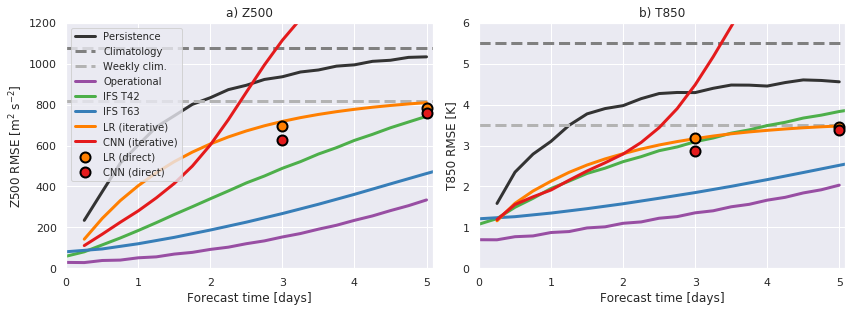

In [171]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 'z', ax=ax1, ylabel=r'Z500 RMSE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 1200))
create_plot(rmse, 't', ax=ax2, ylabel=r'T850 RMSE [K]', title='b) T850', ylim=(0, 6))
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
fig.savefig('../figures/rmse.pdf', bbox_inches='tight')

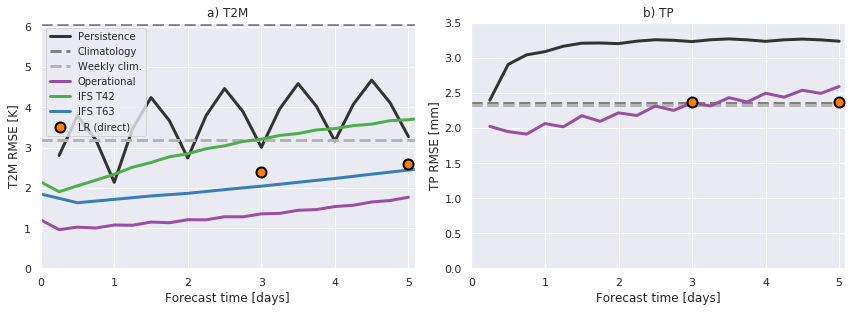

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 't2m', ax=ax1, ylabel=r'T2M RMSE [K]', title='a) T2M', ylim=(0, 6.1))
create_plot(rmse, 'tp', ax=ax2, ylabel=r'TP RMSE [mm]', title='b) TP', ylim=(0, 3.5), mult_tp=1e3)
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
fig.savefig('../figures/rmse2.pdf', bbox_inches='tight')

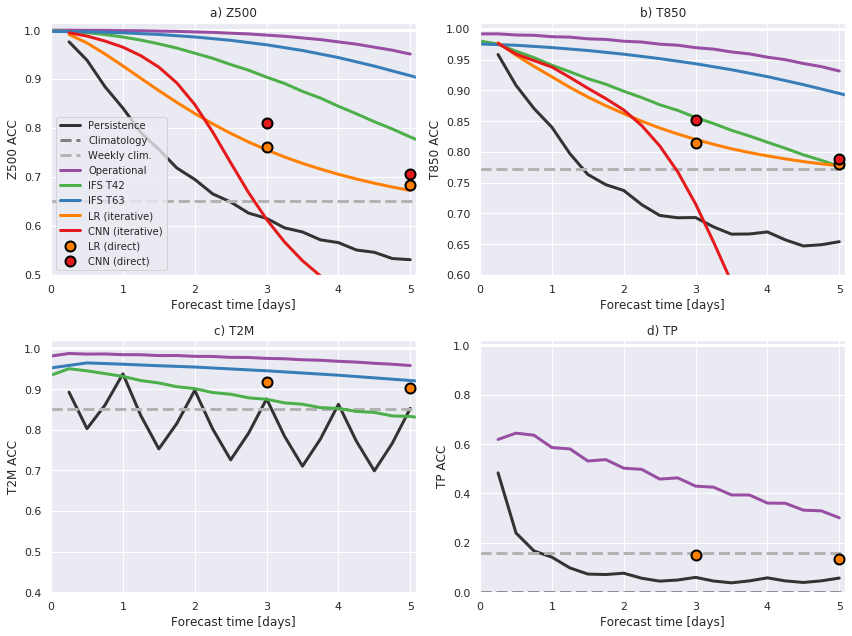

In [173]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
create_plot(acc, 'z', ax=ax1, ylabel=r'Z500 ACC', title='a) Z500', ylim=(0.5, 1.015))
create_plot(acc, 't', ax=ax2, ylabel=r'T850 ACC', title='b) T850', ylim=(0.6, 1.01))
create_plot(acc, 't2m', ax=ax3, ylabel=r'T2M ACC', title='c) T2M', ylim=(0.4, 1.02))
create_plot(acc, 'tp', ax=ax4, ylabel=r'TP ACC', title='d) TP', ylim=(0., 1.02))
ax1.legend(loc=3, ncol=1, fontsize=10)
for ax in axs.flat:
    ax.axhline(1, zorder=1, c='w', lw=3)
plt.tight_layout()
fig.savefig('../figures/acc.pdf', bbox_inches='tight')

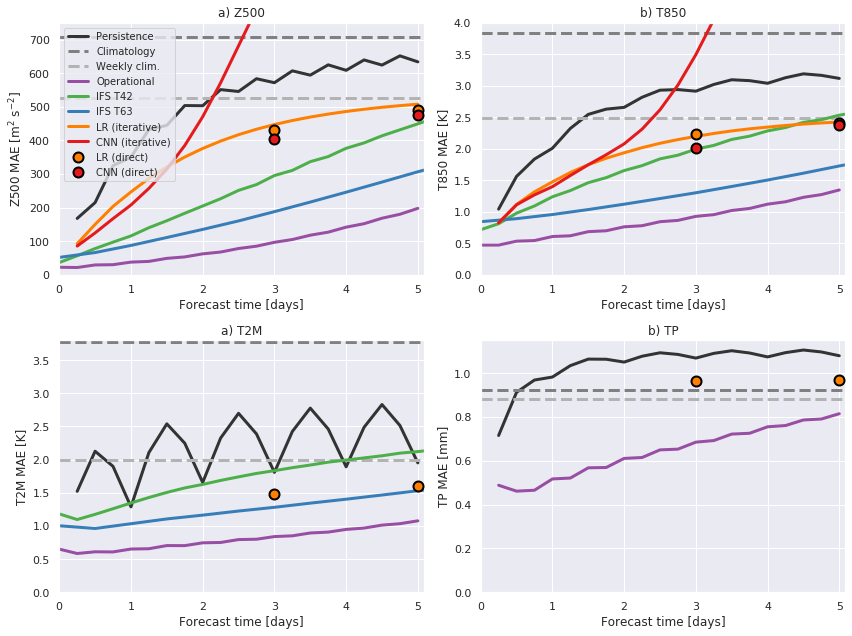

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
create_plot(mae, 'z', ax=ax1, ylabel=r'Z500 MAE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 750))
create_plot(mae, 't', ax=ax2, ylabel=r'T850 MAE [K]', title='b) T850', ylim=(0, 4))
create_plot(mae, 't2m', ax=ax3, ylabel=r'T2M MAE [K]', title='a) T2M', ylim=(0, 3.8))
create_plot(mae, 'tp', ax=ax4, ylabel=r'TP MAE [mm]', title='b) TP', ylim=(0, 1.15), mult_tp=1e3)
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
fig.savefig('../figures/mae.pdf', bbox_inches='tight')

In [107]:
# for tables. Yeah I know ugly formatting...
for k, v in rmse.items():
    if hasattr(v, 'lead_time'):
        print(k, v.sel(lead_time=[72, 120]).to_dataframe())
    else:
        print(k, v)

Persistence                      z         t        tp       t2m
lead_time                                           
72          936.007855  4.292918  0.003231  3.004453
120        1033.287067  4.556234  0.003236  3.270669
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 1.075e+03
    t        float64 5.512
    tp       float64 0.002362
    t2m      float64 6.071
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 815.8
    t        float64 3.503
    tp       float64 0.002329
    t2m      float64 3.19
Operational            surface  heightAboveGround  number         t           z       t2m  \
lead_time                                                                       
72               0                  2       0  1.355497  153.097846  1.352441   
120              0                  2       0  2.031626  334.104949  1.765122   

                 tp

In [128]:
# for tables
for k, v in acc.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[72, 120]).to_dataframe().round(2)

        print(k, df)
    else:
        print(k, v)

Persistence               z     t    tp   t2m
lead_time                        
72         0.62  0.69  0.06  0.88
120        0.53  0.65  0.06  0.85
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 -2.341e-05
    t        float64 2.339e-05
    tp       float64 -2.126e-06
    t2m      float64 -2.873e-05
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 0.6516
    t        float64 0.7728
    tp       float64 0.1587
    t2m      float64 0.852
Operational            surface  heightAboveGround  number     t     z   t2m    tp
lead_time                                                            
72               0                  2       0  0.97  0.99  0.98  0.43
120              0                  2       0  0.93  0.95  0.96  0.30
IFS T42               z     t   t2m
lead_time                  
72         0.90  0.86  0.87
120        0.78  0.78  0.83
IFS T63

In [129]:
# for tables
for k, v in mae.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[72, 120]).to_dataframe()
        try:
            df['tp'] *= 1000
        except KeyError:
            pass
        df['z'] = df['z'].round()
        print(k, df.round(2))
    else:
        print(k, v)

Persistence                z     t    tp   t2m
lead_time                         
72         572.0  2.91  1.07  1.81
120        634.0  3.12  1.08  1.95
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 708.4
    t        float64 3.838
    tp       float64 0.0009213
    t2m      float64 3.768
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 525.4
    t        float64 2.481
    tp       float64 0.0008833
    t2m      float64 1.997
Operational            surface  heightAboveGround  number     t      z   t2m    tp
lead_time                                                             
72               0                  2       0  0.93   97.0  0.84  0.69
120              0                  2       0  1.35  198.0  1.08  0.81
IFS T42                z     t   t2m
lead_time                   
72         295.0  1.99  1.83
120        449.0  2.53  2.12
IFS T63  

## Other figures for paper

In [10]:
import cartopy.crs as ccrs

In [11]:
sns.set_style('dark')

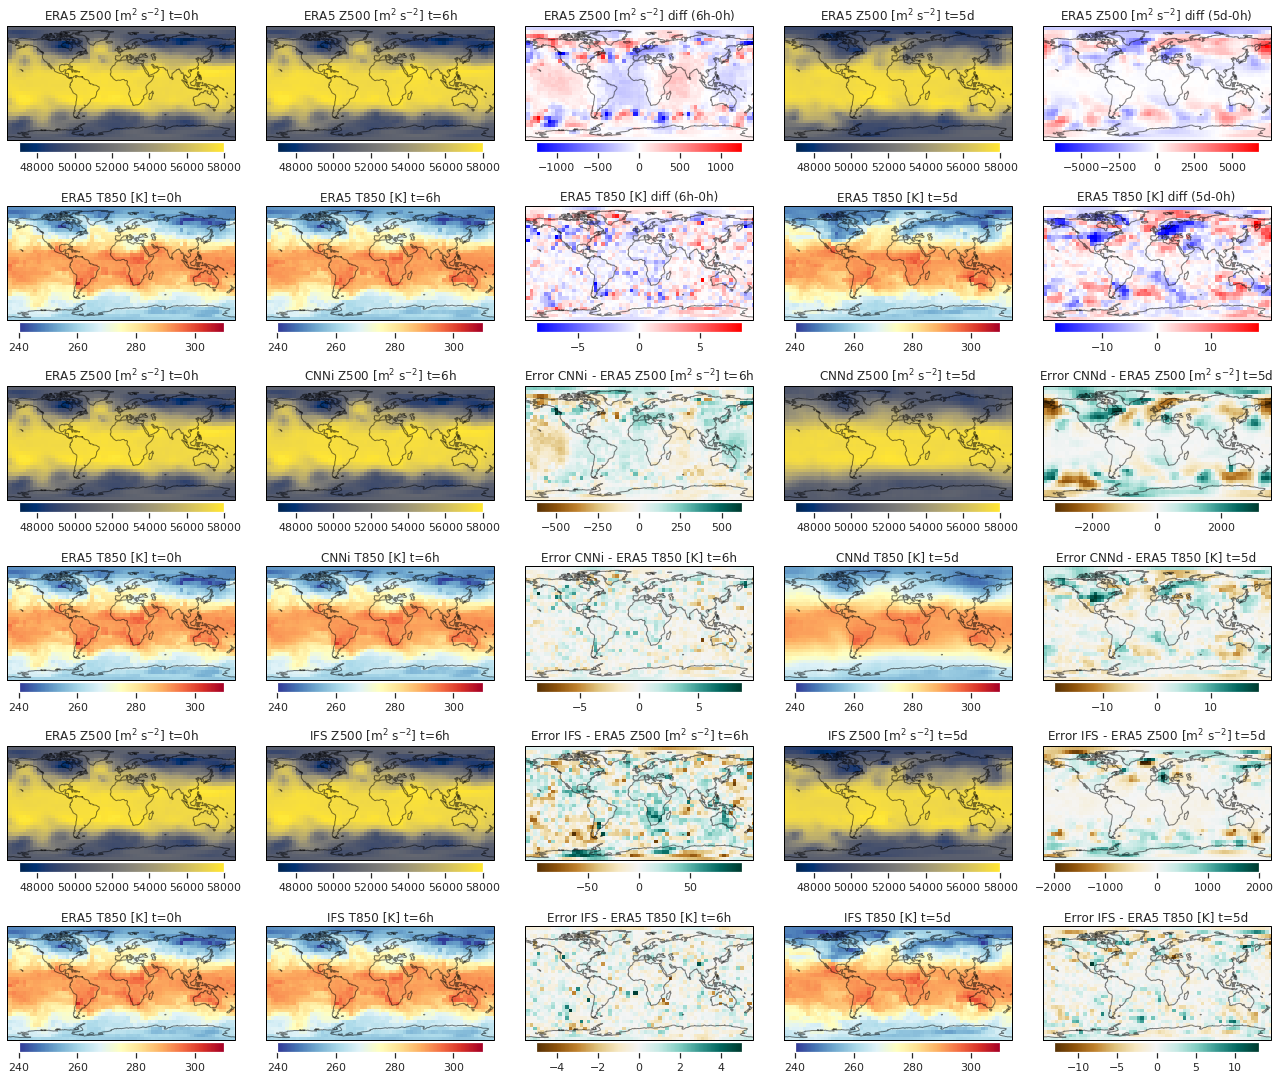

In [35]:
cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)

fig, axs = plt.subplots(6, 5, figsize=(18, 15), subplot_kw={'projection': ccrs.PlateCarree()})
# True
for iax, var, cmap, r, t in zip(
    [0, 1], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid_data[var].isel(time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        valid_data[var].isel(time=6)-valid_data[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], valid_data[var].isel(time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        valid_data[var].isel(time=5*24)-valid_data[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [2, 3], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], cnn_6h_iter[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNi {t} t=6h')
    imcol(axs[iax,2], 
        cnn_6h_iter[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), cmap=cmap_error,
        title=f'Error CNNi - ERA5 {t} t=6h')
    imcol(axs[iax,3], cnn_5d[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNd {t} t=5d')
    imcol(axs[iax,4], 
        cnn_5d[var].isel(time=0) - valid_data[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error CNNd - ERA5 {t} t=5d')

# IFS
for iax, var, cmap, r, t in zip(
    [4, 5], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], tigge[var].isel(time=0).sel(lead_time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], tigge[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=6h')
    imcol(axs[iax,2], 
        tigge[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), cmap=cmap_error,
          title=f'Error IFS - ERA5 {t} t=6h')
    imcol(axs[iax,3], tigge[var].isel(time=0).sel(lead_time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=5d')
    imcol(axs[iax,4], 
        tigge[var].isel(time=0).sel(lead_time=5*24) - valid_data[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error IFS - ERA5 {t} t=5d')
for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
plt.savefig('../figures/examples.pdf', bbox_inches='tight')
# plt.savefig('../figures/examples.jpeg', bbox_inches='tight', dpi=300)

In [30]:
def plot_map(data, fn, cmap, vmin, vmax):
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                  add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    I.set_edgecolor('face')
    ax.set_xticks([]); ax.set_yticks([]); ax.coastlines(alpha=0.5, lw=2)
    plt.subplots_adjust(0, 0, 1, 1)
    fig.savefig(fn, bbox_inches=0, transparent='true')

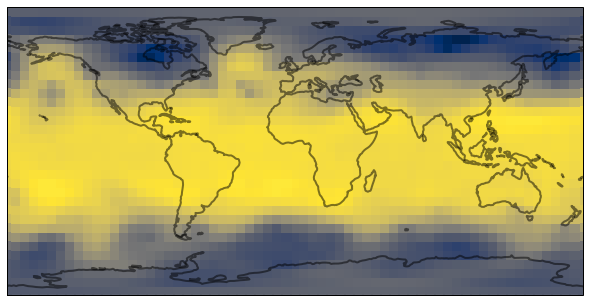

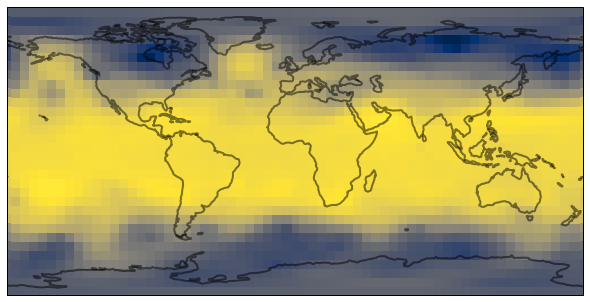

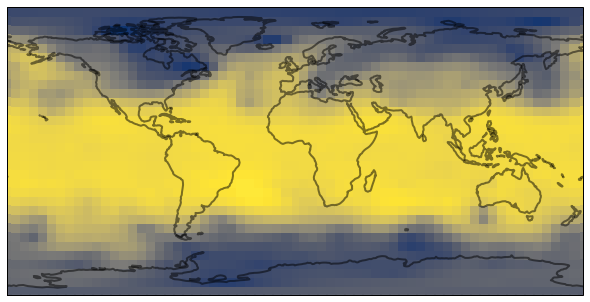

In [32]:
plot_map(valid_data.z.isel(time=0), '../figures/z_0.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=6), '../figures/z_6h.pdf', 'cividis', 47000, 58000)
plot_map(valid_data.z.isel(time=5*24), '../figures/z_5d.pdf', 'cividis', 47000, 58000)

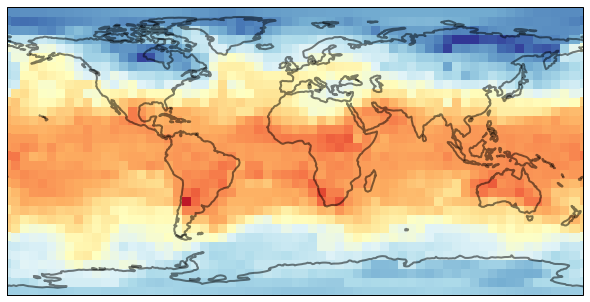

In [ ]:
plot_map(valid_data.t.isel(time=0), '../figures/t_0.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=6), '../figures/t_6h.pdf', 'RdYlBu_r', 240, 310)
plot_map(valid_data.t.isel(time=5*24), '../figures/t_5d.pdf', 'RdYlBu_r', 240, 310)

# Same for higher resolutions

Let's now see how the number change if we do the same for higher resolutions.

In [5]:
res = '2.8125'
DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [6]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [7]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')

In [9]:
# Convert from geopotential height to geopotential
tigge_raw_z = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/z*.nc').squeeze()
tigge_raw_t = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/t*.nc').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
htt

In [10]:
tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [11]:
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [12]:
# Convert from geopotential height to geopotential
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30660)
Coordinates:
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 64, 128), meta=np.ndarray>

In [13]:
tigge_raw = tigge_raw.drop('gh')

In [15]:
tigge = convert_time(tigge_raw, 21)

In [16]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 64, lead_time: 21, lon: 128, time: 1460)
Coordinates:
  * lat        (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lat, lon) float32 258.30826 ... 253.88545
    z          (time, lead_time, lat, lon) float32 50955.645 ... 49957.51

In [19]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_{res}deg.nc')

In [20]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
# t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

In [21]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
# t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [22]:
rmse_persistence = evaluate_iterative_forecast(persistence, valid_data).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

In [23]:
rmse = xr.merge(
    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology, 
         tigge_rmse#, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology',
         'tigge'#, 't42'
        ]
    )],
)

In [24]:
rmse.to_netcdf(f'{PREDDIR}rmse_{res}.nc')

In [25]:
for var in rmse:
    if 'lead_time' in rmse[var].coords:
        print(var, rmse[var].sel(lead_time=[3*24, 5*24]).values)

z_persistence [ 935.87036589 1033.14894667]
t_persistence [4.29551858 4.55898008]
t_tigge [1.35465153 2.03015878]
z_tigge [153.1443925  334.11416358]


In [26]:
for var in rmse:
    if 'lead_time' not in rmse[var].coords:
        print(var, rmse[var].values)

z_climatology 1075.1918267920362
t_climatology 5.521677286348359
z_weekly_climatology 815.6050736811139
t_weekly_climatology 3.5057840813981054


The number are almost identical to the 5.625deg verification. I did not do the verification for 1.4 degrees yet but would expect the results to be similar. These results are reassuring and indicate that we can just verify at 5.625 degrees without losing too much information.

# The End